## Goal:
Simulate current NBA players' careers in order to generate more descriptive career outlook clustering that will serve as the target variable for our modeling. 

Import packages & data

In [1]:
! pip install lifelines sportsreference yellowbrick
import pandas as pd
import numpy as np
import getpass
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from lifelines import CoxPHFitter
from sportsreference.nba.roster import Player
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(40, 24)})

     |████████████████████████████████| 327kB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 481kB 6.5MB/s eta 0:00:01
     |████████████████████████████████| 266kB 15.7MB/s eta 0:00:01
     |████████████████████████████████| 829kB 20.8MB/s eta 0:00:01
     |████████████████████████████████| 5.7MB 7.8MB/s eta 0:00:01
  Created wheel for autograd: filename=autograd-1.3-cp37-none-any.whl size=47990 sha256=7b49d379d46cabd4e27784bd1693a53b9bec8f1728cdd942d91b486e6876918a
  Stored in directory: /home/jpcp73/.cache/pip/wheels/42/62/66/1121afe23ff96af4e452e0d15e68761e3f605952ee075ca99f
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491057 sha256=930782c3f14375cee957c67ebd4632f894cf7300827b8fa0ebb9abe45cef7f2e
  Stored in directory: /home/jpcp73/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built autograd future


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
mypasswd = getpass.getpass()
conn = psycopg2.connect(database = 'cs20_group4',
                              user = 'jpcp73', #replace with pawprint
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)
cursor = conn.cursor()

········


In order to properly assess the 2020 draft class, we need to account for censoring in our NBA data. Given that there are hundreds of players still playing in the league, and who therefore have no finished their career, we need to project out how long we expect those players to remain in the league, and how well they will perform over those remaining seasons. Only then can we fairly assign their career a quality score.

The data pulled in below will pull in the relevant information we need from historical NBA data in order to make those predictions.

In [3]:
nba = pd.read_sql_query("""
SELECT
    nba.player_id
    , nba.player_name
    , nba.season
    , nba.box_plus_minus
    , nba.defensive_box_plus_minus
    , nba.defensive_win_shares
    , nba.minutes_played
    , nba.offensive_win_shares
    , nba.offensive_box_plus_minus
    , nba.player_efficiency_rating
    , nba.value_over_replacement_player as vorp
    , nba.win_shares
    , nba.win_shares_per_48_minutes
    , nba.age
    , min.win_shares_per_minute
    , CASE
        WHEN cr.player_id IS NULL
            THEN 1
            ELSE 0
        END as out_of_league
    , p.height
    , p.weight
    , p.nba_draft_pick
FROM nba_player_season_totals nba
JOIN player_master_table p ON nba.player_id = p.nba_id
JOIN nba_player_per_minute_stats_season min ON nba.player_id = min.player_id
                                                AND nba.season = min.season
LEFT JOIN nba_current_rosters cr ON nba.player_id = cr.player_id
WHERE nba.games_played IS NOT NULL
    AND nba.minutes_played IS NOT NULL
""", con = conn)
nba = nba.drop_duplicates(subset = ['player_id', 'season'])
nba.dropna(subset = ['defensive_box_plus_minus', 'defensive_win_shares', 'offensive_box_plus_minus',
                     'offensive_win_shares', 'player_efficiency_rating', 'vorp'],
          inplace = True)

In [4]:
adv_metrics = ['box_plus_minus', 'defensive_box_plus_minus', 'defensive_win_shares',
              'offensive_box_plus_minus', 'offensive_win_shares', 'defensive_box_plus_minus', 
              'player_efficiency_rating', 'vorp', 'win_shares', 'win_shares_per_minute']

Rescale columns needed for our quality score metric to a uniform distribution, then filter data to only relevant columns.

In [5]:
nba = nba[['player_id', 'player_name', 'season', 'minutes_played', 'age', 'out_of_league',
          'height', 'weight', 'nba_draft_pick'] + adv_metrics]
qt = QuantileTransformer()
nba = nba[['player_id', 'player_name', 'season', 'age', 'box_plus_minus',
           'height', 'weight', 'nba_draft_pick','win_shares', 'minutes_played',
           'player_efficiency_rating', 'vorp', 'out_of_league']]
nba['win_shares_per_minute'] = nba.win_shares / nba.minutes_played
nba['composite_score'] = qt.fit_transform(nba[['box_plus_minus', 'win_shares',
                                               'player_efficiency_rating', 'vorp']]).sum(axis = 1)
nba['composite_score'] = qt.fit_transform(np.array(nba.composite_score).reshape(-1, 1))

# Pull in data for 2020 season

We do not have data from the 2019-20 season in our database, so we must scrape that data from sportsreference. The below query will pull in the relevant players, which we'll then use in our scraping.

In [6]:
p_ids = pd.read_sql_query("""
SELECT
    DISTINCT player_id
FROM nba_current_rosters rosters
""", con = conn)
p_ids = p_ids.player_id.to_list()

In [7]:
current_season = pd.DataFrame()

for p in p_ids:
    df = Player(p).dataframe
    df = df.reset_index().rename({'level_0' : 'season'},
                                 axis = 1).query("season == '2019-20'").reset_index(drop = True)
    current_season = pd.concat([current_season, df])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [8]:
current_rosters = pd.read_sql_query("""
SELECT
    r.*
    , p.nba_draft_pick
FROM nba_current_rosters r
JOIN player_master_table p ON r.player_id = p.nba_id
""", con = conn)

Create new dataframe from data for 2019-20 season. We'll need to mark all of these players as still active in the league to use in our survival analysis, and then compute statistics so that it matches the data pulled in above.

In [9]:
df_2020 = current_rosters[['player_id', 'player_name', 'height',
                'weight', 'age', 'nba_draft_pick']].merge(current_season[['player_id', 'box_plus_minus',
                                                                          'win_shares', 'player_efficiency_rating',
                                                                          'value_over_replacement_player', 'minutes_played']],
                                                          on = 'player_id').rename({'value_over_replacement_player' : 'vorp'},
                                                                                   axis = 1)
df_2020['out_of_league'] = 0
df_2020['season'] = 2020
df_2020 = df_2020[['player_id', 'player_name', 'season', 'age', 'box_plus_minus', 'height', 'weight',
                   'nba_draft_pick', 'win_shares', 'minutes_played',
                   'player_efficiency_rating', 'vorp', 'out_of_league']]
df_2020[['box_plus_minus', 'win_shares', 'player_efficiency_rating', 'vorp']] = qt.fit_transform(df_2020[['box_plus_minus', 'win_shares',
                                                                                                          'player_efficiency_rating', 'vorp']])
df_2020['win_shares_per_minute'] = df.win_shares / df.minutes_played
df_2020['composite_score'] = qt.fit_transform(df_2020[['box_plus_minus', 'win_shares',
                                                       'player_efficiency_rating', 'vorp']]).sum(axis = 1)
df_2020['composite_score'] = qt.fit_transform(np.array(df_2020.composite_score).reshape(-1, 1))
df_2020.nba_draft_pick.fillna(61, inplace = True)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (481). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (481). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (481). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [10]:
df_2020.to_csv('../Data/2020_season.csv', index = False)

We can now append this season's data to the rest of our historical data.

In [11]:
nba = pd.concat([nba, df_2020])

Each row in our data is an individual season for a given player. We are going to create a composite score from a handful of advanced metrics to assess the quality of those seasons.

We are now aggregating that data for each player to capture the totality of their career. We'll need to know not only how good/bad they were, but whether or not they're still in the league, and if not, how old they were in their final season, in addition to relevant biometric data. This will allow us to better predict when active players will cycle out of the league for good.

In [12]:
career = nba.groupby(['player_id', 'player_name']).agg({'age' : 'max',
                                                        'height' : 'mean',
                                                        'weight' : 'mean',
                                                        'nba_draft_pick' : 'max',
                                                        'composite_score' : ['sum', 'mean', 'max'],
                                                        'box_plus_minus' : 'count',
                                                        'out_of_league' : 'max'}).reset_index().rename({'box_plus_minus' : 'seasons'},
                                                                                                      axis = 1)
career.columns = ['_'.join(x) for x in career.columns.tolist()]
career.columns = ['player_id', 'player_name', 'age', 'height', 'weight',
                 'nba_draft_pick', 'career_composite_score', 'avg_composite_score',
                 'peak_composite_score', 'seasons', 'out_of_league']
career.nba_draft_pick.fillna(career.nba_draft_pick.max(), inplace = True)
career.dropna(inplace = True)

We are using the CoxPHFitter from the lifelines package to predict how old each active player in our dataset will be when they leave the NBA. Age will be the primary determinant in this, but we will also feed in some exogenous features to the model, as not everyone retires at the same age. Naturally, very good players tend to play longer than bad players. Likewise, we're also including a player's height and weight, as bigger, stronger players may have a better chance to remain in the league for a long time compared to their smaller counterparts.

In [13]:
cph = CoxPHFitter()
survival_cols = ['age', 'career_composite_score', 'avg_composite_score',
                'peak_composite_score', 'out_of_league', 'height', 
                'weight', 'nba_draft_pick']
cph.fit(career[survival_cols], duration_col = 'age', event_col = 'out_of_league')
cph.print_summary()

Predict how old each player will be at retirement. If you've already left the league, this will remain whatever your age is marked as in the aggregated data above. If you have not, it will be some later date.

In [14]:
career['predicted_age_at_retirement'] = cph.predict_median(career[survival_cols])

We can then compute how many remaining seasons each player in our dataset has in the league, on average.

In [15]:
active = career.loc[career.out_of_league == 0].copy().reset_index(drop = True)
active['seasons_remaining'] = (active.predicted_age_at_retirement - active.age).round()
active.loc[active.seasons_remaining < 0, 'seasons_remaining'] = 0

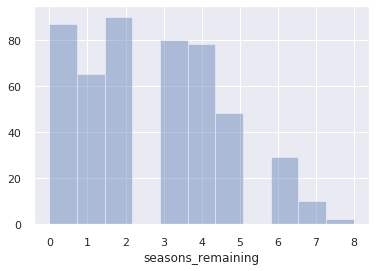

In [16]:
sns.distplot(active.seasons_remaining,
            kde = False);

In [17]:
df_2020 = df_2020.merge(active[['player_id', 'seasons_remaining']],
                        on = 'player_id')

In [18]:
df = nba.dropna()
df['win_shares_per_minute'] = df.win_shares / df.minutes_played

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now that we have an estimate of how much longer each player will play in the league, we need to fit a model to predict their quality for each of those seasons. To do that, we need data from each player's previous season. For example, your age, height and weight, plus your performance in the 2019-20 season, would be used to predict how well you would perform in 2020-21.

In [19]:
multiple_seasons = df.groupby(['player_id']).player_name.count().reset_index().rename({'player_name' : 'seasons'},
                                                                                      axis = 1).query('seasons > 1').player_id.to_list()

multi = df.loc[df.player_id.isin(multiple_seasons)].sort_values(by = ['player_id', 'age'])

This dataframe will capture the a player's performance in a given season, and their performance in the season prior. We'll use the latter to predict the former.

In [20]:
new_df = pd.DataFrame()
for p in multiple_seasons:
    p_df = multi.loc[multi.player_id == p].reset_index(drop = True)
    p_composites = []
    p_bpm = []
    p_ws = []
    p_min = []
    p_per = []
    p_vorp = []
    p_ws_min = []
    for i in range(len(p_df)):
        if i == 0:
            p_composites.append(None)
            p_bpm.append(None)
            p_ws.append(None)
            p_min.append(None)
            p_per.append(None)
            p_vorp.append(None)
            p_ws_min.append(None)
        else:
            p_composites.append(p_df.iloc[i - 1, :]['composite_score'])
            p_bpm.append(p_df.iloc[i - 1, :]['box_plus_minus'])
            p_ws.append(p_df.iloc[i - 1, :]['win_shares'])
            p_min.append(p_df.iloc[i - 1, :]['minutes_played'])
            p_per.append(p_df.iloc[i - 1, :]['player_efficiency_rating'])
            p_vorp.append(p_df.iloc[i - 1, :]['vorp'])
            p_ws_min.append(p_df.iloc[i - 1, :]['win_shares_per_minute'])
    p_df['previous_season_composite_score'] = p_composites
    p_df['previous_season_box_plus_minus'] = p_bpm
    p_df['previous_season_win_shares'] = p_ws
    p_df['previous_season_minutes_played'] = p_min
    p_df['previous_season_player_efficiency_rating'] = p_per
    p_df['previous_season_vorp'] = p_vorp
    p_df['previous_season_win_shares_per_minute'] = p_ws_min
    new_df = pd.concat([new_df, p_df])

In [21]:
cols = [x for x in new_df.columns.to_list() if 'previous_season' in x]

In [22]:
new_df = new_df.loc[new_df.previous_season_composite_score.notnull()].reset_index(drop = True)
new_df = new_df[['player_id', 'player_name', 'age', 'nba_draft_pick',
                 'height', 'weight', 'composite_score', 'out_of_league'] + cols]

# Train composite score model

In [23]:
reg = LinearRegression()
st = StandardScaler()

In [24]:
features = ['age', 'height', 'weight', 'nba_draft_pick', 'previous_season_composite_score']

In [25]:
x = st.fit_transform(new_df[features])
y = np.array(new_df.composite_score)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
cross_val_score(reg, x, y, scoring = 'r2', cv = 10).mean()

0.5062764757619804

In [28]:
features.remove('previous_season_composite_score')
features.append('composite_score')

In [29]:
st.fit(df_2020[features])

StandardScaler(copy=True, with_mean=True, with_std=True)

We now finally have an estimate of how long each active player has remaining in their career, and a model to predict their performance in subsequent seasons.

The below for loop will take an individual player and simulate out their remaining seasons. For each season, we will predict their performance, update their age, and recalculate how much longer they have remaining in their career. This allows us to simulate more dynamically than just using our initial 'seasons remaining' feature computed above.

In [46]:
df_2020.head()

,player_id,player_name,season,age,box_plus_minus,height,weight,nba_draft_pick,win_shares,minutes_played,player_efficiency_rating,vorp,out_of_league,win_shares_per_minute,composite_score,seasons_remaining
0,cartevi01,Vince Carter,2020,43.153666,0.150000,78.0,220.0,5.0,0.027083,876.0,0.136458,0.047917,0,0.00331,0.050000,0.0
1,chandty01,Tyson Chandler,2020,37.472509,0.451042,84.0,240.0,2.0,0.321875,219.0,0.328125,0.361458,0,NaN,0.357292,1.0
2,anthoca01,Carmelo Anthony,2020,35.816075,0.191667,80.0,240.0,3.0,0.411458,1623.0,0.448958,0.026042,0,NaN,0.264583,2.0
3,korveky01,Kyle Korver,2020,39.016688,0.664583,79.0,212.0,51.0,0.606250,833.0,0.365625,0.645833,0,NaN,0.581250,0.0
4,jamesle01,LeBron James,2020,35.227425,0.993750,81.0,250.0,1.0,0.989583,2094.0,0.978125,0.995833,0,NaN,0.993750,4.0


In [69]:
nba_dict = {}
for p in df_2020.player_id.unique():
    player_df = nba.loc[nba.player_id == p].sort_values(by = 'season').reset_index(drop = True)
    player_df.nba_draft_pick.fillna(61, inplace = True)
    player_dict = {p : {'player_name' : player_df.player_name.to_list(),
                'age' : player_df.age.to_list(),
                'nba_draft_pick' : player_df.nba_draft_pick.to_list(),
                'height' : player_df.height.to_list(),
                'weight' : player_df.weight.to_list(),
                'seasons' : player_df.season.to_list(),
                'composite_score' : player_df.composite_score.to_list(),
                'seasons_remaining' : [df_2020.loc[df_2020.player_id == p]['seasons_remaining'].values[0]] * len(player_df)}}
    while player_dict[p]['seasons_remaining'][-1] > 0:
        player_dict[p]['player_name'].append(player_dict[p]['player_name'][-1])
        player_dict[p]['age'].append(player_dict[p]['age'][-1] + 1)
        player_dict[p]['nba_draft_pick'].append(player_df.nba_draft_pick.min())
        player_dict[p]['height'].append(player_dict[p]['height'][-1])
        player_dict[p]['weight'].append(player_dict[p]['weight'][-1])
        player_dict[p]['seasons'].append(player_dict[p]['seasons'][-1] + 1)
        feat = st.transform([[player_dict[p]['age'][-1],
                              player_dict[p]['height'][-1],
                              player_dict[p]['weight'][-1],
                              player_dict[p]['nba_draft_pick'][-1],
                              player_dict[p]['composite_score'][-1]]]).reshape(1, -1)
        player_dict[p]['composite_score'].append(reg.predict(feat)[0])
        retirement_age = cph.predict_median(np.array([sum(player_dict[p]['composite_score']),
                                                      np.mean(player_dict[p]['composite_score']),
                                                      max(player_dict[p]['composite_score']),
                                                      player_dict[p]['height'][-1],
                                                      player_dict[p]['weight'][-1],
                                                      min(player_dict[p]['nba_draft_pick'])]).reshape(1, -1))
        seasons_remaining = (retirement_age - player_dict[p]['age'][-1]).round()
        player_dict[p]['seasons_remaining'].append(seasons_remaining)
        if len(player_dict[p]['seasons']) >= 25:
            break
    nba_dict.update(player_dict)

In [82]:
player_projections = pd.concat({k: pd.DataFrame(v) for k, v in nba_dict.items()},
                               axis = 0).reset_index().rename({'level_0' : 'player_id',
                                                               'level_1' : 'player_season_number',
                                                               'seasons' : 'season'}, axis = 1)
player_projections.drop(['seasons_remaining'], axis = 1, inplace = True)
player_projections.head()

,player_id,player_season_number,player_name,age,nba_draft_pick,height,weight,season,composite_score
0,cartevi01,0,Vince Carter,21.930635,5.0,78.0,220.0,1999.0,0.879600
1,cartevi01,1,Vince Carter,22.929971,5.0,78.0,220.0,2000.0,0.985042
2,cartevi01,2,Vince Carter,23.932045,5.0,78.0,220.0,2001.0,0.993504
3,cartevi01,3,Vince Carter,24.931381,5.0,78.0,220.0,2002.0,0.954500
4,cartevi01,4,Vince Carter,25.930717,5.0,78.0,220.0,2003.0,0.887914


Define the schema for our data table

In [90]:
c_table = []
for c in player_projections.columns:
    if player_projections[c].dtype in [float, int, 'int32', 'int64']:
        c_table.append('{} numeric'.format(c))
    else:
        c_table.append('{} varchar({})'.format(c, max([len(str(x)) for x in player_projections[c] if x is not None])))

Drop the `nba_player_projections` table in case we need to rerun the code and update the table

In [91]:
cursor = conn.cursor()

create_table = 'DROP TABLE IF EXISTS nba_player_projections; '
create_table += 'CREATE TABLE nba_player_projections ({})'.format(', '.join(c for c in c_table))

cursor.execute(create_table)
conn.commit()

Insert our nba career projections into the `nba_player_projections` data table.

In [93]:
df = player_projections.where(pd.notnull(player_projections), None)

cursor = conn.cursor()

INSERT_SQL = 'INSERT INTO nba_player_projections'
INSERT_SQL += '({}) VALUES'.format(', '.join([x for x in df.columns]))
INSERT_SQL += '({})'.format(''.join(['%s,' * len(df.columns)])[:-1])

with conn, conn.cursor() as cursor:
    for row in df.itertuples(index=False, name=None):
        cursor.execute(INSERT_SQL, row)

The below chart plots each active player's career arc. The data up through the current season is quite fuzzy, after which it is easy to see where our predictions take over. We've highlighted a handful of famous players to spot check our results.

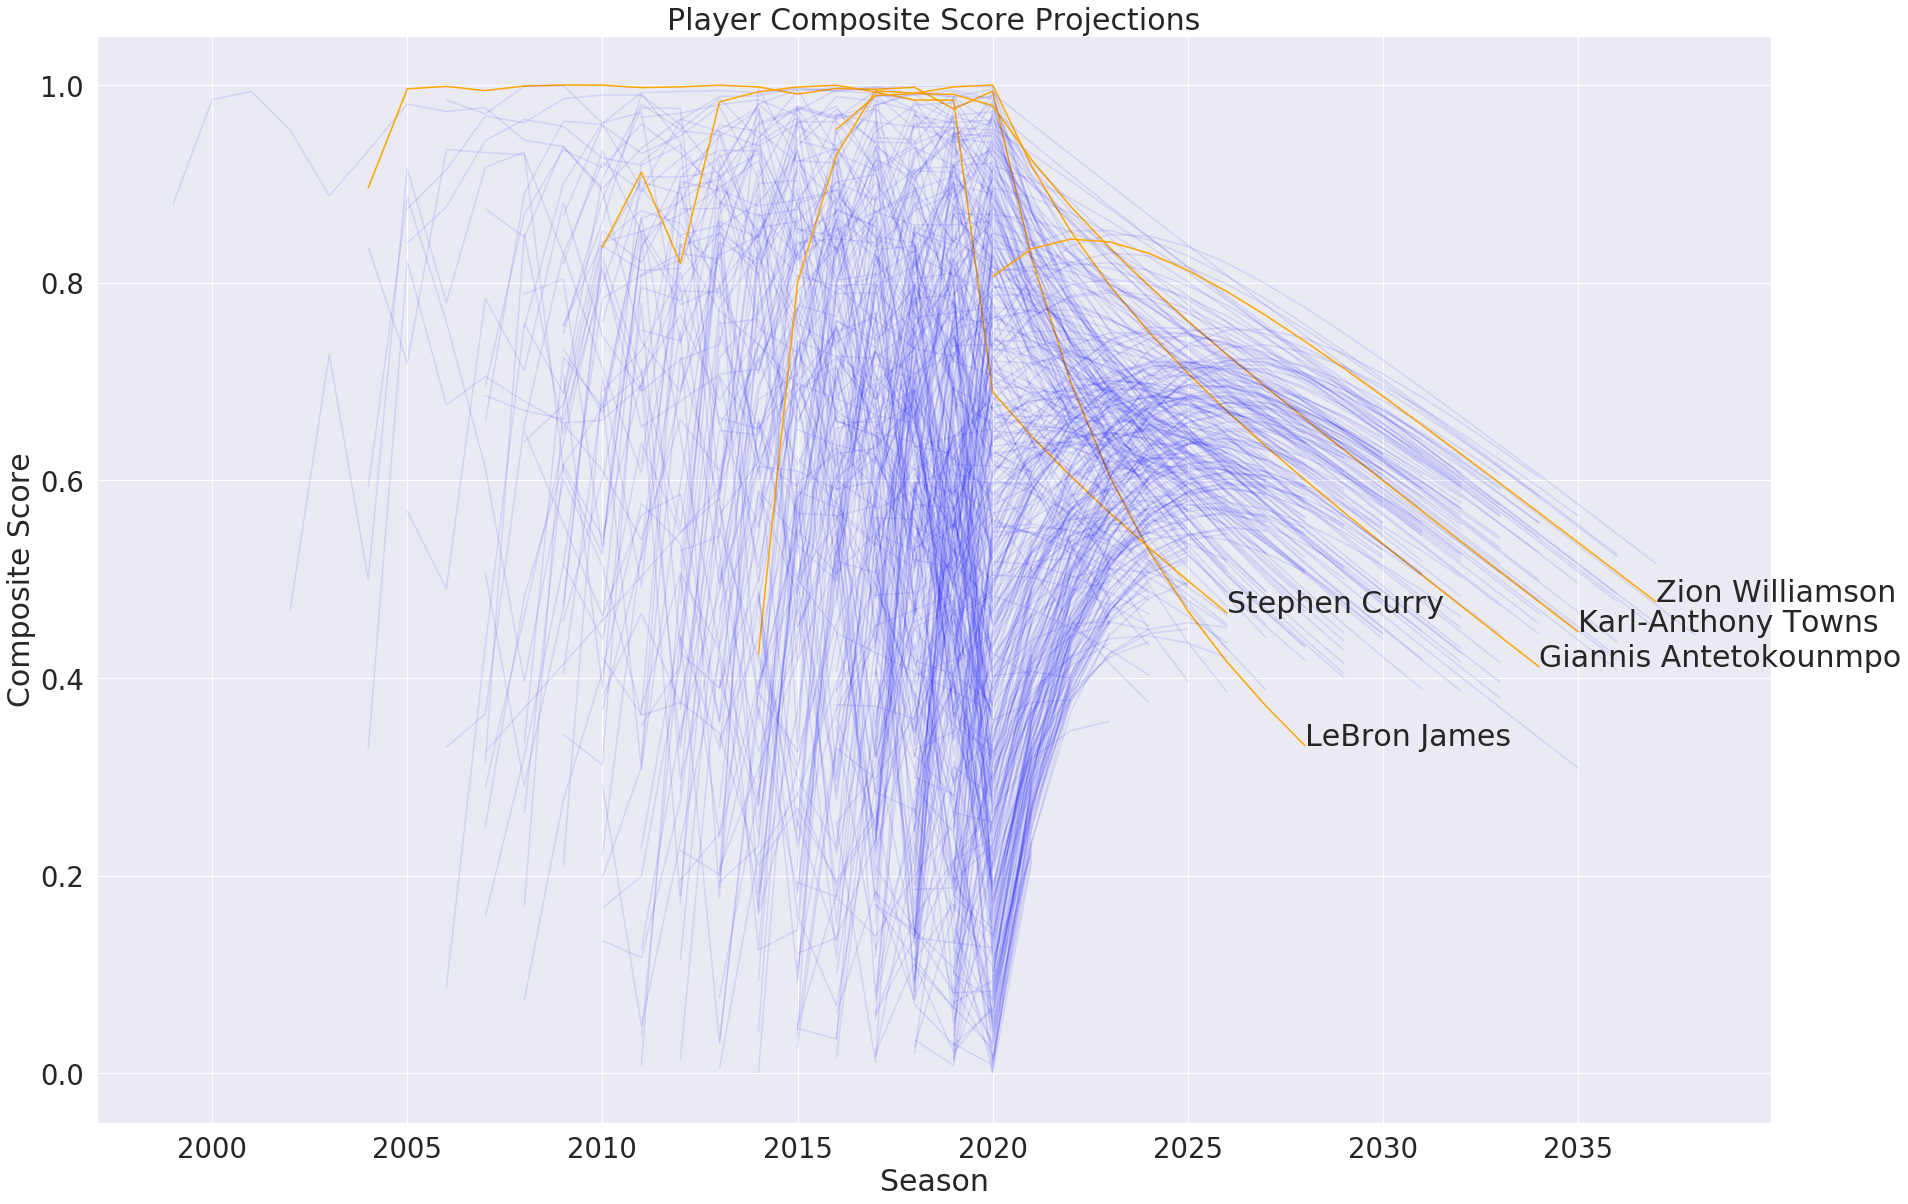

In [31]:
sns.set(rc = {'figure.figsize':(30, 20)}, font_scale=2.5)
for p in nba_dict:
    if nba_dict[p]['player_name'] in ['LeBron James', 'Zion Williamson', 'Stephen Curry', 'Karl-Anthony Towns', 'Giannis Antetokounmpo']:
        plt.plot(nba_dict[p]['seasons'],
        nba_dict[p]['composite_score'],
         color = 'orange',
        alpha = 1)
    else:
        plt.plot(nba_dict[p]['seasons'],
                nba_dict[p]['composite_score'],
                 color = 'blue',
                alpha = 0.1)
    if nba_dict[p]['player_name'] in ['LeBron James', 'Zion Williamson', 'Stephen Curry', 'Karl-Anthony Towns', 'Giannis Antetokounmpo']:
        plt.text(nba_dict[p]['seasons'][-1],
                 nba_dict[p]['composite_score'][-1],
                 nba_dict[p]['player_name'])
plt.xlabel('Season')
plt.ylabel('Composite Score')
plt.title('Player Composite Score Projections');

We can then take these simulations and store them in their own dataset.

In [32]:
ids = []
pl = []
age = []
sea = []
rm = []
cs = []
peak = []
for i in nba_dict:
    ids.append(i)
    pl.append(nba_dict[i]['player_name'])
    age.append(nba_dict[i]['age'])
    sea.append(nba_dict[i]['seasons'][-1])
    rm.append(len(nba_dict[i]['seasons']))
    cs.append(sum(nba_dict[i]['composite_score']))
    peak.append(max(nba_dict[i]['composite_score']))
    
projections = pd.DataFrame.from_dict({'player_id' : ids,
                                      'player_name' : pl,
                                      'age' : age,
                                      'seasons_in_nba' : rm,
                                      'final_season' : sea,
                                      'career_composite_score' : cs,
                                      'peak_composite_score' : peak})

Finally, we want to combine our projections with historical data to give ourselves a full picture of every player in our data. That way, we can assess every player on the same scale before assigning a quality score.

In [33]:
player_careers = nba.loc[~nba.player_id.isin(df_2020.player_id.unique())].groupby(['player_id', 'player_name']).agg({'age' : 'max',
                                                                                                                     'minutes_played' : 'count',
                                                                                                                     'season' : 'max',
                                                                                                                     'composite_score' : 'sum'}).reset_index().rename({'minutes_played' : 'seasons_in_nba',
                                                                                                                                                                       'season' : 'final_season',
                                                                                                                                                                       'composite_score' : 'career_composite_score'},
                                                                                                                                                                       axis = 1)
player_careers = player_careers.merge(nba.groupby(['player_id']).composite_score.max().reset_index(),
                                      on = 'player_id').rename({'composite_score' : 'peak_composite_score'},
                                                              axis = 1)
final_df = pd.concat([player_careers, projections])
final_df['career_composite_score_scaled'] = qt.fit_transform(np.array(final_df.career_composite_score).reshape(-1, 1))
final_df['avg_composite_score'] = qt.fit_transform(np.array(final_df.career_composite_score / final_df.seasons_in_nba).reshape(-1, 1))
final_df['peak_composite_score'] = qt.fit_transform(np.array(final_df.peak_composite_score).reshape(-1, 1))

Simple plot of the most valuable players in our data, after adding in projections.

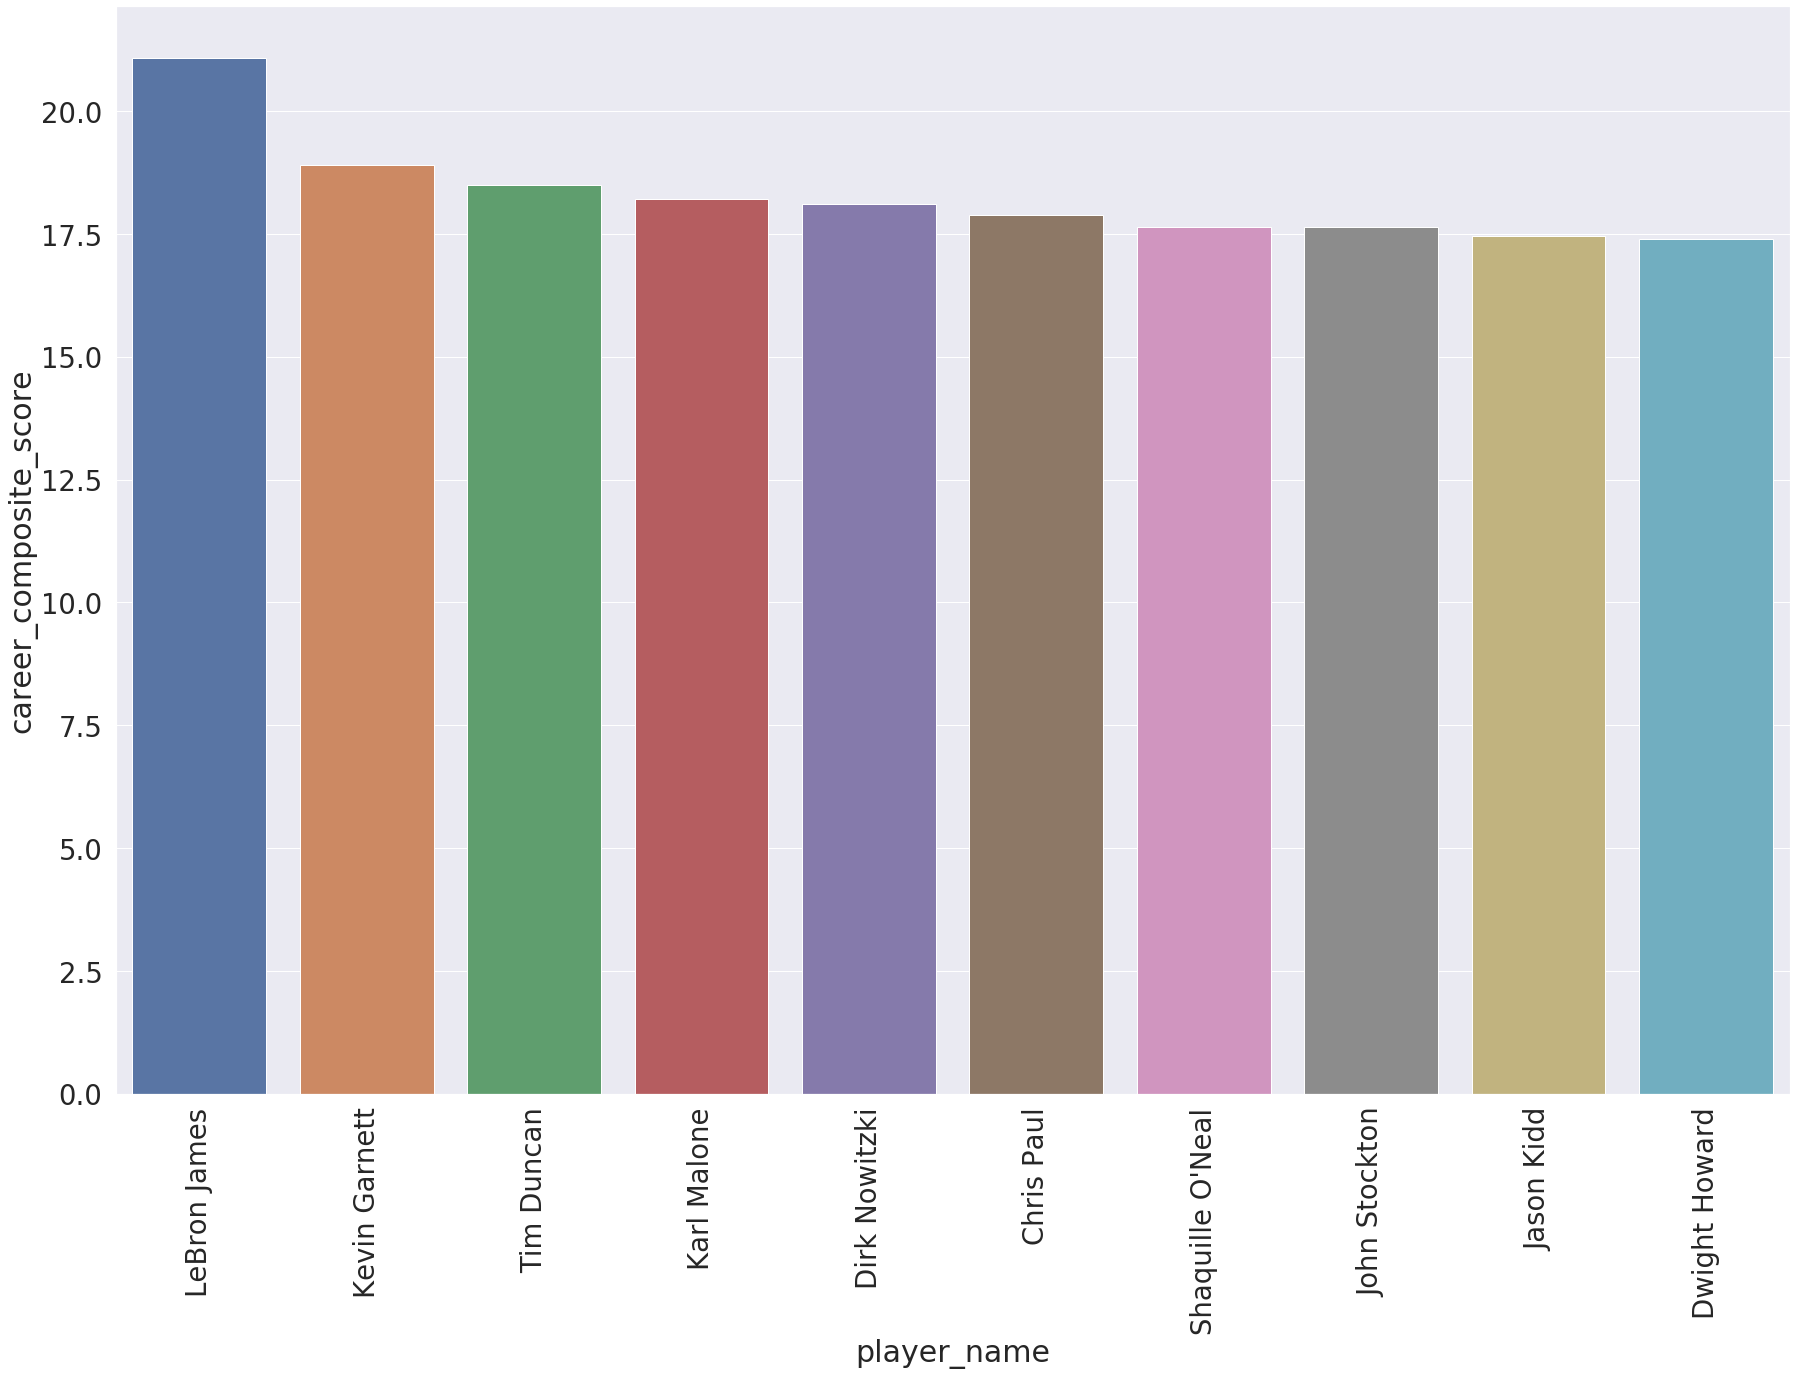

In [34]:
sns.barplot(x = 'player_name',
           y = 'career_composite_score',
           data = final_df.sort_values(by = 'career_composite_score',
                                       ascending = False).head(10))
plt.xticks(rotation = 90);

The last thing we want to do is create our quality score for each player. So was this player a superstar, or someone barely hanging on to their career in the league. We decided on six different clusters using the features below to create those groupings, which we've visualized below.

In [35]:
kmeans = KMeans(n_clusters = 6, random_state = 0)
final_df['cluster'] = kmeans.fit_predict(np.array(final_df[['career_composite_score_scaled',
                                                            'avg_composite_score', 'peak_composite_score']]))

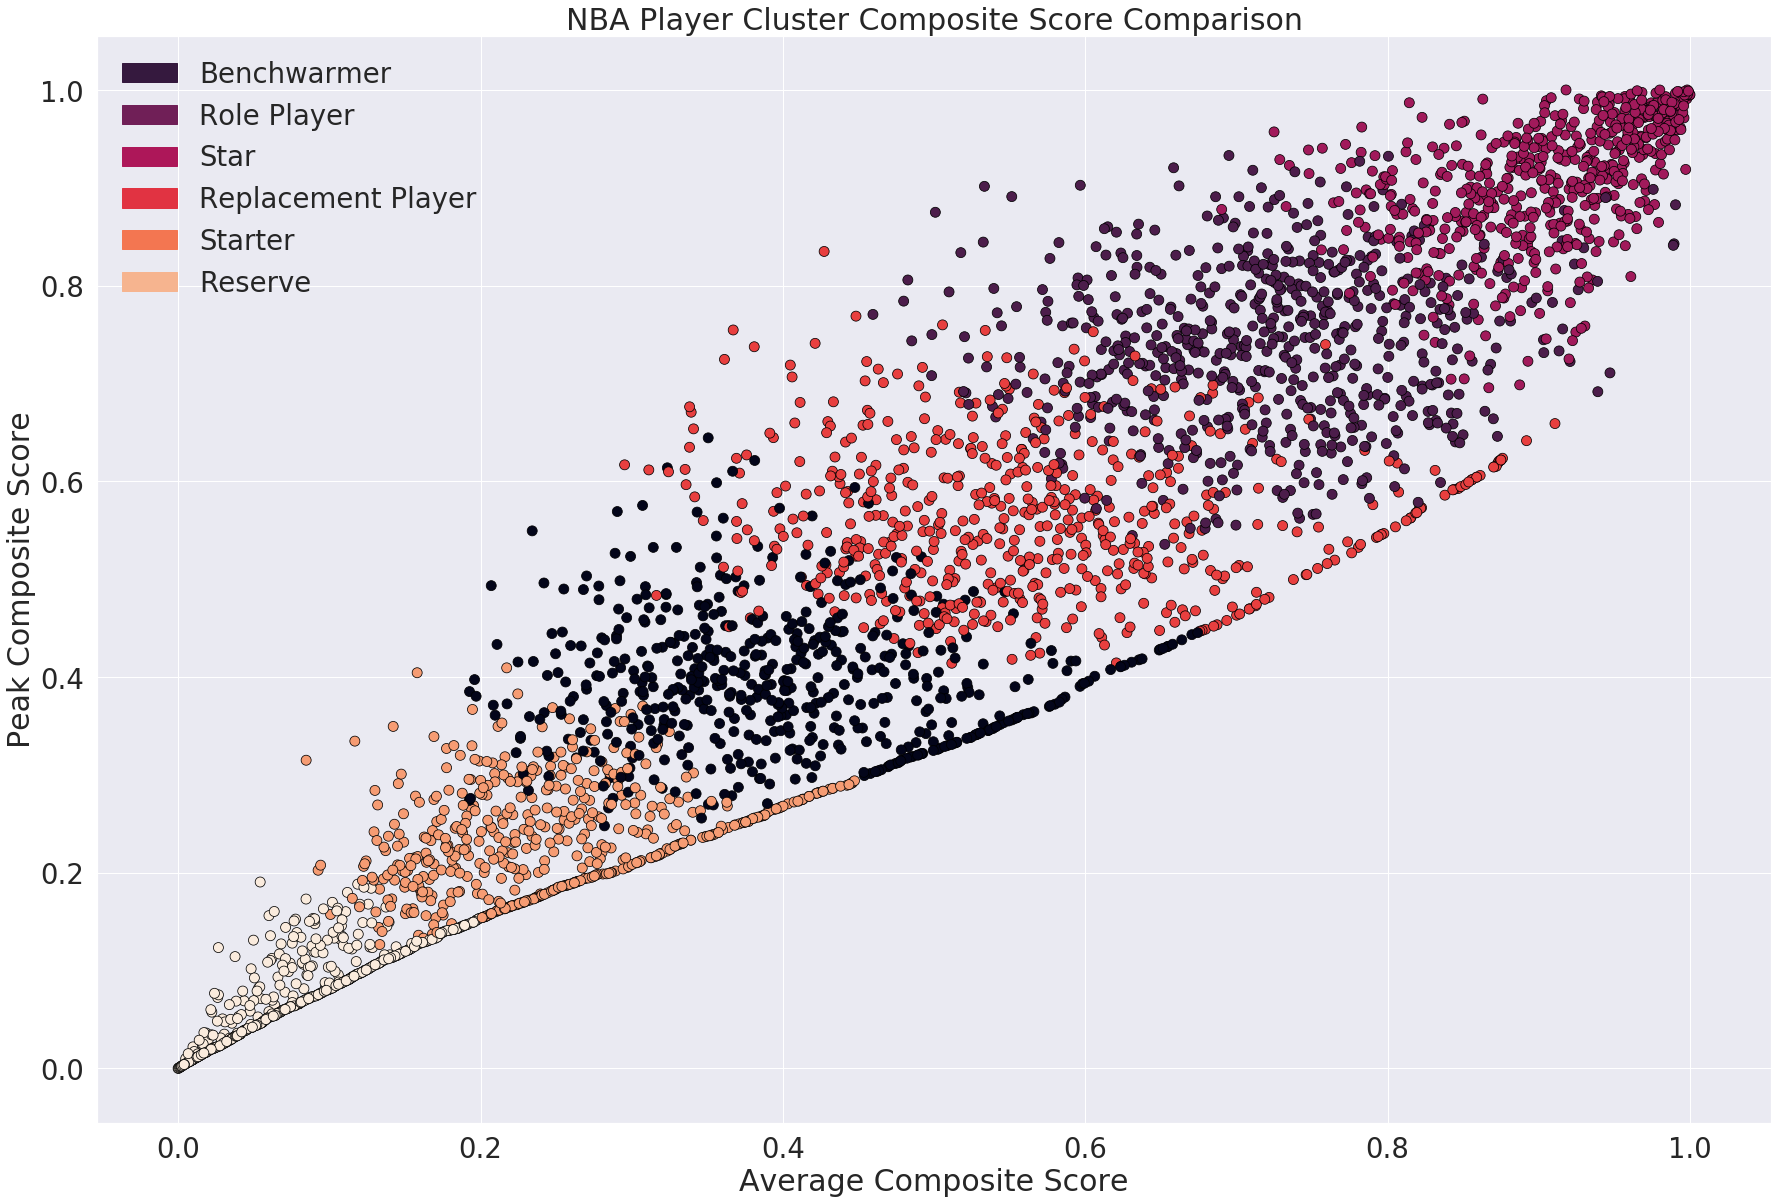

In [36]:
import matplotlib.patches as mpatches
sns.set(rc = {'figure.figsize':(30, 20)}, font_scale=2.5)
ax = sns.scatterplot(x = 'avg_composite_score',
               y = 'peak_composite_score',
               hue = 'cluster',
                s = 100,
                edgecolor = 'black',
                palette = 'rocket',
                legend = 'full',
               data = final_df)
plt.xlabel('Average Composite Score')
plt.ylabel('Peak Composite Score')
plt.title('NBA Player Cluster Composite Score Comparison')

color_1 = mpatches.Patch(color='#35193e', label='Benchwarmer')
color_2 = mpatches.Patch(color='#701f57', label='Role Player')
color_3 = mpatches.Patch(color='#ad1759', label='Star')
color_4 = mpatches.Patch(color='#e13342', label='Replacement Player')
color_5 = mpatches.Patch(color='#f37651', label='Starter')
color_6 = mpatches.Patch(color='#f6b48f', label='Reserve')


plt.legend(handles=[color_1, color_2, color_3, color_4, color_5, color_6])

Analyze the results of each cluster before assigning group names to each.

In [37]:
cluster_results = final_df.groupby(['cluster']).agg({'player_id' : 'nunique',
                                                     'seasons_in_nba' : 'mean',
                                                     'career_composite_score_scaled' : 'mean',
                                                     'avg_composite_score' : 'mean',
                                                     'peak_composite_score' : 'mean'}).sort_values(by = 'career_composite_score_scaled',
                                                                                                   ascending = False)
cluster_results

,player_id,seasons_in_nba,career_composite_score_scaled,avg_composite_score,peak_composite_score
cluster,,,,,
2,581,13.492255,0.899991,0.905463,0.907093
1,660,9.493939,0.737457,0.719051,0.737866
3,602,5.712625,0.548866,0.566613,0.563654
0,569,3.643234,0.403164,0.401424,0.395935
4,543,2.316759,0.250382,0.248305,0.236196
5,544,1.393382,0.081081,0.081784,0.078345


In [38]:
for i in range(6):
    print('Cluster {} example'.format(i))
    print(final_df.loc[final_df.cluster == i].sample(n = 1)['player_name'].values[0])
    print('-' * 10)

Cluster 0 example
Josh Grant
----------
Cluster 1 example
Harvey Grant
----------
Cluster 2 example
Oliver Miller
----------
Cluster 3 example
Henry Sims
----------
Cluster 4 example
Greg Sutton
----------
Cluster 5 example
Cedric Hunter
----------


Create a name for each cluster, then assign each player the appropriate moniker.

In [39]:
clusters_dict = {}
cluster_names = ['Star', 'Starter', 'Role Player', 'Reserve', 'Benchwarmer', 'Replacement Player']

for i in range(len(cluster_results)):
    c = {cluster_results.index[i] : cluster_names[i]}
    clusters_dict.update(c)

clusters_dict

{2: 'Star',
 1: 'Starter',
 3: 'Role Player',
 0: 'Reserve',
 4: 'Benchwarmer',
 5: 'Replacement Player'}

In [40]:
final_df['role'] = None
for c in final_df.cluster.unique():
    final_df.loc[final_df.cluster == c, 'role'] = clusters_dict[c]

Store our data in our database for future analyses.

In [41]:
c_table = []
for c in final_df.columns:
    if final_df[c].dtype in [float, int, 'int32', 'int64']:
        c_table.append('{} numeric'.format(c))
    else:
        c_table.append('{} varchar({})'.format(c, max([len(str(x)) for x in final_df[c] if x is not None])))

In [42]:
cursor = conn.cursor()

create_table = 'DROP TABLE IF EXISTS nba_player_roles; '
create_table += 'CREATE TABLE nba_player_roles ({})'.format(', '.join(c for c in c_table))

cursor.execute(create_table)
conn.commit()

In [43]:
df = final_df.where(pd.notnull(final_df), None)

cursor = conn.cursor()

INSERT_SQL = 'INSERT INTO nba_player_roles'
INSERT_SQL += '({}) VALUES'.format(', '.join([x for x in df.columns]))
INSERT_SQL += '({})'.format(''.join(['%s,' * len(df.columns)])[:-1])

with conn, conn.cursor() as cursor:
    for row in df.itertuples(index=False, name=None):
        cursor.execute(INSERT_SQL, row)